# Causal inference model for auditory-visual duration discrimination with conflict

# Notations:
- $S_a$: true auditory duration
- $S_v$: true visual duration
- $m_a$: noisy auditory measurement
- $m_v$: noisy visual measurement
- $\sigma_a$: auditory noise (standard deviation)
- $\sigma_v$: visual noise (standard deviation)
- $C$: common cause (1 if common, 2 if independent)
- $\mu_p$: prior bias (assumed to be 0 for simplicity)
- $\sigma_p$: prior noise (assumed to be infinite for simplicity)
- $\sigma_{av,a}$: effective auditory noise in the AV condition
- $\sigma_{av,v}$: effective visual noise in the AV condition
- $\hat{S}_{av,a}$: estimated auditory duration in the AV condition
- $\hat{S}_{av,v}$: estimated visual duration in the AV condition
- $\hat{S}_{CI,t}$: final internal estimate for the test interval
- $\hat{S}_{CI,s}$: final internal estimate for the standard interval



In [1]:
estColor='maroon'  # Color for the estimate line

# 1 - Reliability based duration estimation assuming fully fusion


$\hat{S}_{av,a}=\hat{S}_{av,v}= \frac{\sigma_{av,a}^{-2} m_a+\sigma_{av,v}^{-2} m_v}{\sigma_{av,a}^{-2} + \sigma_{av,v}^{-2}}$ 

Here since my stimulus is a duration from observers perspective L(s|m) would not be exactly gaussian around stimulus. Because stimulus cant be negative and observation cant be negative as well. And the observation would depend on the stimulus duration longer durations most probably lead to higher noise. In order to solve this problem I think using a logarithmic gaussian or log of S would be better. What do you think



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
#import normal
from scipy.stats import norm

# unimodal measurements
from scipy.stats import truncnorm

def sigmaFlex(S,sigma, weber_k=0.2):
    return sigma * (1 + weber_k * S)

def unimodalMeasurements(sigma, S, n=500):
    # Define lower bound (0) and calculate the standardized lower bound for truncnorm
    a = (0 - S) / sigma
    b = np.inf  # no upper bound restriction
    m = truncnorm.rvs(a, b, loc=S, scale=sigma, size=n)
    return m

# probability density function of a Gaussian distribution
def gaussianPDF(x,S, sigma):
	return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-((x-S)**2)/(2*(sigma**2)))

# likelihood function
def likelihood( S, sigma):
    #S=np.log(S)  # convert S to log scale
    # P(m|s) # likelihood of measurements given the true duration
    m=np.linspace(0, S + 10*sigma, 500)
    #p_m=gaussianPDF(m,S,sigma) # calculate the probability density function
    # Alternatively, you can use scipy's norm.pdf for the same result
    p_m=norm.pdf(m, loc=S, scale=sigma) # uncomment
    return m, p_m

def plotLikelihood(S,sigma):
	x, p_x = likelihood(S, sigma)
	plt.plot(x, p_x, label='Likelihood Function')
	plt.xlabel('Hypothetical stimuli $S$')
	plt.ylabel('Probability Density')
	plt.title('Measurement distribution $p(m|s)$')
	plt.legend()

def plotMeasurements(sigma, S):
    m = unimodalMeasurements(sigma, S)
    plt.hist(m, bins=50, density=True, alpha=0.5, label='Measurements Histogram')
    plt.xlabel('Hypothetical stimuli $S$')
    plt.ylabel('Density')
    plt.title('Unimodal Measurements Histogram')
    plt.legend()      


def plotMeasurementsAndLikelihood(sigma, S):
    plt.figure(figsize=(10, 6))
    plotMeasurements(sigma, S)
    plotLikelihood(S, sigma)
    #plt.xlim(0, 1)

    plt.show()

# interactive plotting
import ipywidgets as widgets
interact(plotMeasurementsAndLikelihood,
         sigma=widgets.FloatSlider(value=0.2, min=0.1, max=5.0, step=0.01, description='Sigma'),
         S=widgets.FloatSlider(value=0.5, min=-1.5, max=2.5, step=0.02, description='True Duration S'))




interactive(children=(FloatSlider(value=0.2, description='Sigma', max=5.0, min=0.1, step=0.01), FloatSlider(va…

<function __main__.plotMeasurementsAndLikelihood(sigma, S)>

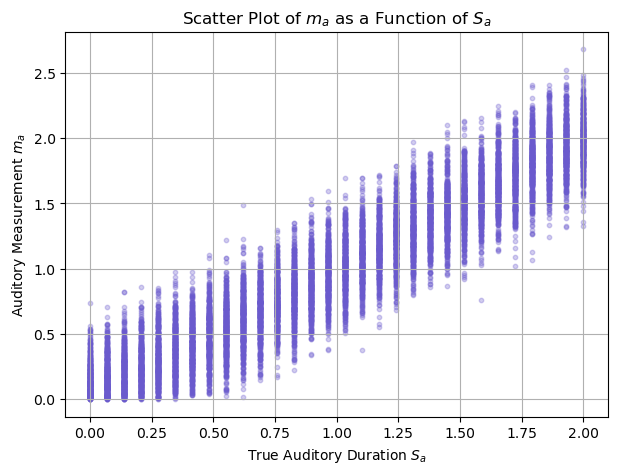

interactive(children=(FloatSlider(value=0.5, description='Measurement m0', max=2.5, step=0.01), FloatSlider(va…

<function __main__.plot_likelihood_S_given_m(m0, S_grid, sigma_a=0.2)>

In [3]:
# Scatter plot of m_a as a function of S_a
def scatterMeasurements_vs_Sa(sigma_a=0.2, n=500):
    S_a_values = np.linspace(-0, 2, 30)
    m_a_all = []
    S_a_all = []
    for S_a in S_a_values:
        m_a = unimodalMeasurements(sigma_a, S_a, n)
        S_a_all.extend([S_a]*n)
        m_a_all.extend(m_a)
    plt.figure(figsize=(7, 5))
    plt.scatter(S_a_all, m_a_all, alpha=0.3, s=10, color='slateblue')
    plt.xlabel('True Auditory Duration $S_a$')
    plt.ylabel('Auditory Measurement $m_a$')
    plt.title('Scatter Plot of $m_a$ as a Function of $S_a$')
    plt.grid(True)
    plt.show()

scatterMeasurements_vs_Sa()

# Plot PDF of measurements for a single S_a
def plot_measurement_pdf(S_a=1.0, sigma_a=0.2):
    m = np.random.normal(S_a, sigma_a, 100)
    pdf = norm.pdf(m, S_a, sigma_a)
    plt.figure(figsize=(7, 4))
    plt.scatter(m, pdf, color='crimson', label=f'PDF for $S_a$={S_a}')
    plt.xlabel('Auditory Measurement $m_a$')
    plt.ylabel('Probability Density')
    plt.title('PDF of $m_a$ for a Single $S_a$')
    plt.legend()
    plt.grid(True)
    plt.show()

#interact(plot_measurement_pdf, S_a=(0.0, 2.0, 0.1), sigma_a=(0.01, 1.0, 0.01))

def plot_likelihood_S_given_m(m0, S_grid, sigma_a=0.2):
    """Plot L(S | m0) for a single observed measurement m0."""
    likelihood = norm.pdf(m0, S_grid, sigma_a)   # same formula, S is now the variable
    plt.figure(figsize=(7,4))
    plt.plot(S_grid, likelihood, color='royalblue')
    plt.xlabel('Hypothesised stimulus $S_a$')
    plt.ylabel(r'Likelihood $L(S_a\mid m_0)$')
    plt.title(fr'Likelihood of $S_a$ given a single measurement $m_0={m0:.2f}$')
    plt.grid(True)
    plt.show()

interact(plot_likelihood_S_given_m, m0=FloatSlider(value=0.5, min=0, max=2.5, step=0.01, description='Measurement m0'),
            S_grid=widgets.fixed(np.linspace(0, 2.5, 100)),
            sigma_a=FloatSlider(value=0.2, min=0.01, max=1.0, step=0.01, description='Noise $\sigma_a$'))

### 2.1 Fusion (C=1)

### **2.1.1 Fusion of one interval**

$$\hat{S}_{av,a}=\hat{S}_{av,v}= \frac{\sigma_{av,a}^{-2} m_a+\sigma_{av,v}^{-2} m_v}{\sigma_{av,a}^{-2} + \sigma_{av,v}^{-2}}\\ 
= w_aS_a+w_vS_v$$ 
$$J_a=\frac{1}{\sigma_{av,a}^{2}} \\
J_v=\frac{1}{\sigma_{av,v}^{2}}\\
\sigma_{av}^2=\frac{1}{J_1+J_2}$$

$$p(S|m_a,m_v)\sim p(S)p(m_a|S)p(m_v|S)\\
p(S|m_a,m_v)\sim N(\hat S_{av},\sigma_{av}^2)\\
$$


In [4]:
# compute fused estimate (reliability weighted avg)
def fusionAV(sigmaAV_A,sigmaAV_V, S_a, visualConflict):
	m_a=unimodalMeasurements(sigmaAV_A, S_a)
	S_v=S_a+visualConflict
	m_v = unimodalMeasurements(sigmaAV_V,S_v)  # visual measurement
	# compute the precisons inverse of variances
	J_AV_A= sigmaAV_A**-2 # auditory precision
	J_AV_V=sigmaAV_V**-2 # visual precision
	# compute the fused estimate using reliability weighted averaging
	hat_S_AV= (J_AV_A*m_a+J_AV_V*m_v)/(J_AV_V+J_AV_A)
	sigma_S_AV_hat=np.sqrt(1 / (J_AV_A + J_AV_V))  # fused standard deviation

	return hat_S_AV, sigma_S_AV_hat


In [5]:
# create interactive plot 
from ipywidgets import interact, FloatSlider, IntSlider
#import normal
from scipy.stats import norm

def generativeModelPlot(sigmaAV_A, sigmaAV_V, S_a,visualConflict,showHistograms=True):
    # Go analytic likelihoods
    # S: True Stim
    S_v=S_a+visualConflict
    # plot the likelihoods
    plt.figure(figsize=(10, 6))
    # line plot probablity distribution of auditory measurement
    colorA='teal'
    x_a,p_a = likelihood( S_a, sigmaAV_A) # probability density function for auditory measurement
    plt.plot(x_a, p_a, color=colorA, label='Auditory PDF')
    plt.axvline(S_a, color=colorA, label= "Auditory Stimulus", linestyle='--')

    # Plot measurements and true stimulus value for Visual
    x_v= np.linspace(S_v - 4*sigmaAV_V, S_v + 4*sigmaAV_V, 500)
    colorV='forestgreen'
    x_v,p_v=likelihood(S_v, sigmaAV_V) # args: mean, std and m_v means measurement
    plt.plot(x_v, p_v, color=colorV, label='Visual PDF')
    plt.axvline(S_v, color=colorV, label= "Visual Stimulus", linestyle='--')

    # Fused estimate
    hat_S_AV , sigma_S_AV_hat= fusionAV(sigmaAV_A, sigmaAV_V, S_a, visualConflict)
    plt.axvline(np.mean(hat_S_AV), color=estColor, label='$\hat S_{av}$Fused Estimate', linestyle='--')
    
    # fused likelihood analytically
    J_a = sigmaAV_A**-2  # auditory precision
    J_v = sigmaAV_V**-2  # visual precision

    w_a = J_a / (J_a + J_v)  # weight for auditory
    w_v = 1 - w_a  # weight for visual
    mu_Shat = w_a * S_a + w_v * S_v  # fused mean
    
    x_av = np.linspace(mu_Shat - 4 * sigma_S_AV_hat, mu_Shat + 4 * sigma_S_AV_hat, 500)
    p_S_AV= gaussianPDF(x_av,mu_Shat,sigma_S_AV_hat)
    # normalize p

    #x_av, p_S_AV = likelihood(mu_Shat, sigma_S_AV_hat)
    plt.plot(x_av, p_S_AV, color=estColor, label=f'$S$ Fused PDF')
    plt.axvline(mu_Shat, color=estColor, linestyle='--')

    # plot the measurements
    if showHistograms:
        plt.hist(unimodalMeasurements(sigmaAV_A, S_a), bins=30, density=True, alpha=0.5, color='teal')
        plt.hist(unimodalMeasurements(sigmaAV_V, S_v), bins=30, density=True, alpha=0.5, color='forestgreen')
        plt.hist(hat_S_AV, bins=30, density=True, alpha=0.5, color=estColor )
    plt.title('Generative Model for AV Fusion')
    plt.xlabel('Internal Measurement / Estimate')
    plt.ylabel('Probability Density')
    plt.legend(loc='best')
    #plt.tight_layout()
    #plt.xlim(-1.5)

# Interactive Plotting
interact(generativeModelPlot,
         sigmaAV_A=widgets.FloatSlider(value=0.2, min=0.1, max=5.0, step=0.1, description='$Sigma_{AV,A}'),
         sigmaAV_V=widgets.FloatSlider(value=0.2, min=0.1, max=5.0, step=0.1, description='Sigma AV V'),
         S_a=widgets.FloatSlider(value=0.3, min=-1.5, max=1.5, step=0.1, description='True Duration S_a'),
         visualConflict=widgets.FloatSlider(value=0.9, min=0.0, max=2.0, step=0.1, description='Visual Conflict'),
         showHistograms=widgets.Checkbox(value=True, description='Show Histograms'))


interactive(children=(FloatSlider(value=0.2, description='$Sigma_{AV,A}', max=5.0, min=0.1), FloatSlider(value…

<function __main__.generativeModelPlot(sigmaAV_A, sigmaAV_V, S_a, visualConflict, showHistograms=True)>

## 2.1.2 Fusion of two intervals

\begin{align}
\Delta_{t-s}=w_a({m_a^t} -m_a^S)+ w_v ({m_v^t} -m_v^s)\\
=w_a\Delta S_a +w_v \Delta S_v
\end{align}

In [6]:
# create interactive plot 
from ipywidgets import interact, FloatSlider, IntSlider
#import normal
from scipy.stats import norm

def generativeModelPlot(sigmaAV_A, sigmaAV_V, S_a,visualConflict,showHistograms=True):
    # Go analytic likelihoods
    # S: True Stim
    S_v=S_a+visualConflict


    # plot the likelihoods
    plt.figure(figsize=(10, 6))
    # line plot probablity distribution of auditory measurement
    colorA='teal'
    x_a,p_a = likelihood( S_a, np.sqrt(2*sigmaAV_A)) # probability density function for auditory measurement
    plt.plot(x_a, p_a, color=colorA, label='Auditory PDF')
    plt.axvline(S_a, color=colorA, label= "Auditory Stimulus", linestyle='--')

    # Plot measurements and true stimulus value for Visual
    x_v= np.linspace(S_v - 4*sigmaAV_V, S_v + 4*sigmaAV_V, 500)
    colorV='forestgreen'
    x_v,p_v=likelihood(S_v,np.sqrt(2*sigmaAV_V)) # args: mean, std and m_v means measurement
    plt.plot(x_v, p_v, color=colorV, label='Visual PDF')
    plt.axvline(S_v, color=colorV, label= "Visual Stimulus", linestyle='--')

    # Fused estimate
    hat_S_AV , sigma_S_AV_hat= fusionAV(sigmaAV_A, sigmaAV_V, S_a, visualConflict)
    plt.axvline(np.mean(hat_S_AV), color=estColor, label='$\hat S_{av}$Fused Estimate', linestyle='--')
    
    # fused likelihood analytically
    J_a = sigmaAV_A**-2  # auditory precision
    J_v = sigmaAV_V**-2  # visual precision

    w_a = J_a / (J_a + J_v)  # weight for auditory
    w_v = 1 - w_a  # weight for visual
    mu_Shat = w_a * S_a + w_v * S_v  # fused mean
    
    x_av = np.linspace(mu_Shat - 4 * sigma_S_AV_hat, mu_Shat + 4 * sigma_S_AV_hat, 500)
    p_S_AV= gaussianPDF(x_av,mu_Shat,np.sqrt(2)*sigma_S_AV_hat)

    #x_av, p_S_AV = likelihood(mu_Shat, sigma_S_AV_hat)
    plt.plot(x_av, p_S_AV, color=estColor, label=f'$S$ Fused PDF')
    plt.axvline(mu_Shat, color=estColor, linestyle='--')

    # plot the measurements
    if showHistograms:
        plt.hist(unimodalMeasurements(sigmaAV_A, S_a), bins=30, density=True, alpha=0.5, color='teal')
        plt.hist(unimodalMeasurements(sigmaAV_V, S_v), bins=30, density=True, alpha=0.5, color='forestgreen')
        plt.hist(hat_S_AV, bins=30, density=True, alpha=0.5, color=estColor )
    plt.title('Generative Model for AV Fusion')
    plt.xlabel('Internal Measurement / Estimate')
    plt.ylabel('Probability Density')
    plt.legend(loc='best')
    #plt.tight_layout()
    plt.xlim(-1.5,1.5)

# Interactive Plotting
interact(generativeModelPlot,
         sigmaAV_A=widgets.FloatSlider(value=0.2, min=0.1, max=5.0, step=0.1, description='Sigma AV,A'),
         sigmaAV_V=widgets.FloatSlider(value=0.2, min=0.1, max=5.0, step=0.1, description='Sigma AV V'),
         S_a=widgets.FloatSlider(value=0.3, min=-1.5, max=1.5, step=0.1, description='True Duration S_a'),
         visualConflict=widgets.FloatSlider(value=0.9, min=0.0, max=2.0, step=0.1, description='Visual Conflict'),
         showHistograms=widgets.Checkbox(value=True, description='Show Histograms'))


interactive(children=(FloatSlider(value=0.2, description='Sigma AV,A', max=5.0, min=0.1), FloatSlider(value=0.…

<function __main__.generativeModelPlot(sigmaAV_A, sigmaAV_V, S_a, visualConflict, showHistograms=True)>

## 2.2 Conflict - Causal inference of 2-IFC Duration Difference (C=1 and C=2 )

### 2.2.1 No common cause (C=2)


In the case of no common cause, the observer infers that the auditory and visual durations are independent, so that the posterior estimate of different modalities are independent as well.

$$
\hat S_{av,a}= m_a, \hat S_{av,v}= m_v, \\
\sigma_{av,a}^2=\sigma_a^2, \sigma_{av,v}^2=\sigma_v^2, 
$$

We assume that common cause inference is not a binary decision, but rather a continuous variable that can take any value between 0 and 1. The observer can then use this variable to weight the auditory and visual durations in their final estimate. The final estimate is given by:

$$
\hat S_{av,a}= \hat S_{av,a} \cdot P(C=1|m_a, m_v) + \hat S_{av,a} \cdot (1 - P(C=1|m_a, m_v))
$$

Where $P(C=1|S_a, S_v)$ is the posterior probability of the common cause given the auditory and visual durations. Observer has measurements:

$$
\text{Auditory measurement}= m_a\\
\text{Visual measurement}= m_v\\

$$

Each is noisy sample:

$$
m_a \sim N(S_a, \sigma_{av,a}^2)\\
m_v\sim N(S_v, \sigma_{av,v}^2)\\
$$

Here, measurement noise $\sigma_{av,a}$ and $\sigma_{av,v}$ is fit directly from AV bimodal experiment data; we do not assume they are identical to unimodal noise( $\sigma_{av,a} \ne \sigma_a$) as the variance should depend on the context. 

This model allows the observer to flexibly integrate the auditory and visual durations based on their prior beliefs about the common cause, leading to more accurate estimates of the durations.


In [7]:
# Simulate m_a, m_v and compute likelihood under C=1
def compute_likelihood_C1(m_a, m_v, sigma_a, sigma_v):
    var_sum = sigma_a**2 + sigma_v**2
    likelihood_c1 = (1 / np.sqrt(2 * np.pi * var_sum)) * np.exp(-(m_a - m_v)**2 / (2 * var_sum))
    return likelihood_c1


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# Gaussian PDF
def gaussianPDF(x, mean, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))

# Likelihood function
def likelihood(S, sigma):
    m = np.linspace(S - 4 * sigma, S + 4 * sigma, 500)
    p_m = gaussianPDF(m, S, sigma)
    return m, p_m

# Fusion function
def fusionAV_yo(sigma_a, sigma_v, S_a, conflict):
    S_v = S_a + conflict
    J_a = 1 / sigma_a**2
    J_v = 1 / sigma_v**2
    w_a = J_a / (J_a + J_v)
    w_v = 1 - w_a
    fused = w_a * S_a + w_v * S_v
    fused_sigma = np.sqrt(1 / (J_a + J_v))
    return fused, fused_sigma

# Likelihood under common cause
def compute_likelihood_C1(m_a, m_v, sigma_a, sigma_v):
    var_sum = sigma_a ** 2 + sigma_v ** 2
    return (1 / np.sqrt(2 * np.pi * var_sum)) * np.exp(-((m_a - m_v) ** 2) / (2 * var_sum))

# Interactive causal inference model
def causalInferenceModel(sigmaAV_A, sigmaAV_V, S_a, visualConflict, p_c):
    S_v = S_a + visualConflict

    # Simulate one measurement
    m_a = np.random.normal(S_a, sigmaAV_A)
    m_v = np.random.normal(S_v, sigmaAV_V)

    plt.figure(figsize=(10, 6))

    # Plot likelihoods
    x_a, p_a = likelihood(S_a, sigmaAV_A)
    plt.plot(x_a, p_a, color='teal', label='Auditory PDF')
    plt.axvline(S_a, color='teal', linestyle='--', label='Auditory Stimulus')

    x_v, p_v = likelihood(S_v, sigmaAV_V)
    plt.plot(x_v, p_v, color='forestgreen', label='Visual PDF')
    plt.axvline(S_v, color='forestgreen', linestyle='--', label='Visual Stimulus')

    # Fusion estimate for C=1
    fused_mean, fused_sigma = fusionAV_yo(sigmaAV_A, sigmaAV_V, S_a, visualConflict)

    # C=2 just auditory
    hat_S_AV_A_c2 = S_a

    # Likelihoods
    likeli_c1 = compute_likelihood_C1(m_a, m_v, sigmaAV_A, sigmaAV_V)
    likeli_c2 = norm.pdf(m_a, S_a, sigmaAV_A) * norm.pdf(m_v, S_v, sigmaAV_V)

    # Posterior
    post_c = (likeli_c1 * p_c) / ((likeli_c1 * p_c) + (likeli_c2 * (1 - p_c)))

    # Plot posterior probability of common cause
    plt.plot([0, 1], [post_c, post_c], color='purple', label='P(C=1|m_a, m_v)')
    plt.axhline(post_c, color='purple', linestyle='--')

    # Final estimate
    hat_S_av_a = fused_mean * post_c + hat_S_AV_A_c2 * (1 - post_c)

    # Plot final estimate
    plt.axvline(hat_S_av_a, color=estColor, linestyle='--', label='Final Auditory Estimate')

    # Display posterior as a horizontal line
    plt.text(-1.2, 0.3,
             f"P(C=1|m_a, m_v) ≈ {post_c:.2f}", fontsize=12, color='purple')

    plt.title('Causal Inference: Auditory Duration Estimate')
    plt.xlabel('Internal Measurement / Estimate')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.xlim(-1.5, 2)
    plt.show()

# Interactive controls
interact(causalInferenceModel,
         sigmaAV_A=FloatSlider(value=0.2, min=0.1, max=1.0, step=0.05, description='σ AV,A'),
         sigmaAV_V=FloatSlider(value=0.2, min=0.1, max=1.0, step=0.05, description='σ AV,V'),
         S_a=FloatSlider(value=0.3, min=-1.0, max=1.0, step=0.1, description='S_a'),
         visualConflict=FloatSlider(value=0.6, min=0.0, max=1.5, step=0.1, description='Visual Conflict'),
         p_c=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='P(Common)'));


interactive(children=(FloatSlider(value=0.2, description='σ AV,A', max=1.0, min=0.1, step=0.05), FloatSlider(v…

In [9]:
from scipy.stats import norm

def fusionAV_vectorized(m_a, m_v, sigma_av_a, sigma_av_v):
    """
    Optimal multisensory fusion (MLE) - same as monteCarloClass.py
    Note: This performs fusion in whatever space the measurements are in
    (linear for gaussian, log for lognorm)
    """
    J_AV_A = 1 / sigma_av_a**2
    J_AV_V = 1 / sigma_av_v**2
    fused_S_av = (J_AV_A * m_a + J_AV_V * m_v) / (J_AV_A + J_AV_V)
    return fused_S_av

def p_single(m, sigma, t_min, t_max):
    """
    p(m | C=2) - marginal likelihood for separate causes with bounded uniform prior
    Identical to monteCarloClass.py
    """
    hi_cdf = norm.cdf((t_max - m) / sigma)
    lo_cdf = norm.cdf((t_min - m) / sigma)
    return (hi_cdf - lo_cdf) / (t_max - t_min)

def L_C2(m_a, m_v, sigma_a, sigma_v, t_min, t_max):
    """
    Likelihood of separate sources: product of two marginal likelihoods
    Identical to monteCarloClass.py
    """
    return p_single(m_a, sigma_a, t_min, t_max) * p_single(m_v, sigma_v, t_min, t_max)

def L_C1(m_a, m_v, sigma_a, sigma_v, t_min, t_max):
    """
    Likelihood of common cause - exact implementation from monteCarloClass.py
    """
    sigma_c_sq = (sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2)
    sigma_c = np.sqrt(sigma_c_sq)
    mu_c = (m_a / sigma_a**2 + m_v / sigma_v**2) / (1 / sigma_a**2 + 1 / sigma_v**2)

    hi_cdf = norm.cdf((t_max - mu_c) / sigma_c)
    lo_cdf = norm.cdf((t_min - mu_c) / sigma_c)
    
    expo = np.exp(-(m_a - m_v)**2 / (2 * (sigma_a**2 + sigma_v**2)))
    prior = 1 / (t_max - t_min)

    return prior * sigma_c / np.sqrt(sigma_a**2 * sigma_v**2) * (hi_cdf - lo_cdf) * expo

def posterior_C1(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max):
    """
    Posterior probability of common cause - exact implementation from monteCarloClass.py
    """
    L1 = L_C1(m_a, m_v, sigma_a, sigma_v, t_min, t_max)
    L2 = L_C2(m_a, m_v, sigma_a, sigma_v, t_min, t_max)
    
    # Posterior with numerical stability
    denominator = L1 * p_c + L2 * (1 - p_c)
    
    # Handle both scalar and array cases
    if np.isscalar(denominator):
        if denominator <= 1e-15:
            return 0.0
        postC1 = (L1 * p_c) / denominator
    else:
        postC1 = np.zeros_like(denominator)
        valid_mask = denominator > 1e-15
        postC1[valid_mask] = (L1[valid_mask] * p_c) / denominator[valid_mask]
    
    return postC1

def causalInference_vectorized(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max, model="gaussian"):
    """
    Causal inference model - corrected implementation
    
    Key insight: For lognorm models, all computation happens in log space.
    Only convert to linear scale at the very end for interpretation.
    """
    # Step 1: Perform fusion in the measurement space (linear or log)
    fused_S_av = fusionAV_vectorized(m_a, m_v, sigma_a, sigma_v)
    
    # Step 2: Calculate posterior probability of common cause
    post_C1 = posterior_C1(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max)

    # Step 3: Compute final estimate as weighted average
    # For separate cause (C=2), use auditory measurement
    final_estimate_in_measurement_space = post_C1 * fused_S_av + (1 - post_C1) * m_a

    # Step 4: Convert to linear scale ONLY if we were working in log space
    if model == "lognorm":
        final_estimate = np.exp(final_estimate_in_measurement_space)
    else:
        final_estimate = final_estimate_in_measurement_space

    return final_estimate

In [10]:
def justCausalInference(S_a_s, c, sigma_av_a, sigma_av_v, model="gaussian", p_c=0.5, t_min=0.2, t_max=2.0):
    """
    Simulate causal inference with proper bounded priors - matches monteCarloClass.py
    """
    nSimul = 1000  # Number of simulations
    S_v_s = S_a_s + c  # Visual stimulus based on conflict level
    
    if model == "gaussian":
        # Linear space measurements
        m_a_s_arr = np.random.normal(S_a_s, sigma_av_a, nSimul)
        m_v_s_arr = np.random.normal(S_v_s, sigma_av_v, nSimul)
        # Bounds stay in linear space
        bounds_min, bounds_max = t_min, t_max
    elif model == "lognorm":
        # Log space measurements
        m_a_s_arr = np.random.normal(np.log(S_a_s), sigma_av_a, nSimul)
        m_v_s_arr = np.random.normal(np.log(S_v_s), sigma_av_v, nSimul)
        # Convert bounds to log space for likelihood calculations
        bounds_min, bounds_max = np.log(t_min), np.log(t_max)
    
    # Use the proper causal inference with correct bounds
    est_standard = causalInference_vectorized(m_a_s_arr, m_v_s_arr, sigma_av_a, sigma_av_v, 
                                            p_c, bounds_min, bounds_max, model)
    
    # Return measurements in interpretable space
    if model == "lognorm":
        return est_standard, np.exp(m_a_s_arr), np.exp(m_v_s_arr)
    else:
        return est_standard, m_a_s_arr, m_v_s_arr

## Key Insight: Measurement Space vs. Interpretation Space

**For Gaussian model:**
- Measurements are in linear space: `m_a ~ N(S_a, σ_a²)`
- All computations (fusion, posteriors) happen in linear space
- Final estimate is already in linear space

**For Log-normal model:**
- Measurements are in log space: `m_a ~ N(log(S_a), σ_a²)`
- All computations (fusion, posteriors) happen in **log space**
- `t_min` and `t_max` bounds are converted to log space: `log(t_min), log(t_max)`
- Final estimate is converted to linear space only at the very end: `exp(estimate_in_log_space)`

This ensures that:
1. The bounded uniform prior is applied correctly in log space
2. Fusion weights are computed correctly for log-space measurements
3. Posterior probabilities are calculated with consistent likelihood functions

In [ ]:
from scipy.stats import gaussian_kde

estColor = 'maroon'  # Color for the estimate line

def plotCausalInference(S_a_s, c, sigma_av_a, sigma_av_v, model="gaussian", p_c=0.5, 
                       t_min=0.2, t_max=2.0, show_histograms=True):
    """
    Plot causal inference results using the exact monteCarloClass.py implementation
    """
    # Visual stimulus based on conflict level
    S_v_s = S_a_s + c
    est_standard, m_a_s, m_v_s = justCausalInference(S_a_s, c, sigma_av_a, sigma_av_v, 
                                                    model, p_c, t_min, t_max)
    
    plt.figure(figsize=(12, 8))
    
    # Calculate some example posterior probabilities for display
    if model == "gaussian":
        example_m_a = S_a_s + np.random.normal(0, sigma_av_a, 1)[0]
        example_m_v = S_v_s + np.random.normal(0, sigma_av_v, 1)[0]
    else:  # lognorm
        example_m_a = np.log(S_a_s) + np.random.normal(0, sigma_av_a, 1)[0]
        example_m_v = np.log(S_v_s) + np.random.normal(0, sigma_av_v, 1)[0]
    
    example_post = posterior_C1(example_m_a, example_m_v, sigma_av_a, sigma_av_v, p_c, t_min, t_max)
    
    if show_histograms:
        # Plot histograms
        plt.hist(m_a_s, bins=30, density=True, alpha=0.6, color='teal', label='Auditory measurements')
        plt.hist(m_v_s, bins=30, density=True, alpha=0.6, color='forestgreen', label='Visual measurements')
        plt.hist(est_standard, bins=30, density=True, alpha=0.8, color=estColor, label='Causal inference estimates')
    else:
        # Create empty labels for histograms
        plt.hist([], bins=30, density=True, alpha=0.6, color='teal', label='Auditory measurements')
        plt.hist([], bins=30, density=True, alpha=0.6, color='forestgreen', label='Visual measurements')
        plt.hist([], bins=30, density=True, alpha=0.8, color=estColor, label='Causal inference estimates')
    
    # Plot KDE densities
    if len(est_standard) > 1:  # Avoid KDE with single points
        kde_a = gaussian_kde(m_a_s)
        kde_v = gaussian_kde(m_v_s)
        kde_est = gaussian_kde(est_standard)
        x = np.linspace(t_min - 0.5, t_max + 0.5, 1000)
        plt.plot(x, kde_a(x), color='teal', linewidth=2)
        plt.plot(x, kde_v(x), color='forestgreen', linewidth=2)
        plt.plot(x, kde_est(x), color=estColor, linewidth=2)
    
    # Plot vertical lines for true stimuli and mean estimates
    plt.axvline(S_a_s, color='teal', linestyle='--', alpha=0.8, label=f'True S_a = {S_a_s:.2f}')
    plt.axvline(S_v_s, color='forestgreen', linestyle='--', alpha=0.8, label=f'True S_v = {S_v_s:.2f}')
    plt.axvline(np.mean(est_standard), color=estColor, linestyle='--', alpha=0.8, 
                label=f'Mean estimate = {np.mean(est_standard):.2f}')
    
    # Add parameter bounds
    plt.axvline(t_min, color='gray', linestyle=':', alpha=0.5, label=f't_min = {t_min}')
    plt.axvline(t_max, color='gray', linestyle=':', alpha=0.5, label=f't_max = {t_max}')

    plt.title(f'Causal Inference Model ({model})\n'
              f'Example P(C=1|m_a,m_v) ≈ {example_post:.3f}, p_c = {p_c:.2f}')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Probability Density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim(t_min - 0.2, t_max + 0.2)
    plt.tight_layout()

# Interactive controls for causal inference
interact(plotCausalInference,
         S_a_s=FloatSlider(value=0.5, min=0.2, max=1.8, step=0.1, description='S_a'),
         c=FloatSlider(value=0.3, min=0.0, max=1.0, step=0.1, description='Conflict'),
         sigma_av_a=FloatSlider(value=0.2, min=0.05, max=0.8, step=0.05, description='σ_a'),
         sigma_av_v=FloatSlider(value=0.2, min=0.05, max=0.8, step=0.05, description='σ_v'),
         model=widgets.Dropdown(options=['gaussian', 'lognorm'], value='gaussian', description='Model'),
         p_c=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='P(Common)'),
         t_min=FloatSlider(value=0.2, min=0.1, max=0.5, step=0.05, description='t_min'),
         t_max=FloatSlider(value=2.0, min=1.0, max=3.0, step=0.1, description='t_max'),
         show_histograms=widgets.Checkbox(value=True, description='Show Histograms'));

interactive(children=(FloatSlider(value=0.5, description='S_a', max=1.8, min=0.2), FloatSlider(value=0.3, desc…

In [12]:
import sys
sys.path.append("..")  # Add the parent directory to the system path
import monteCarloClass
#from monteCarloClass import probTestLonger_vectorized_mc
#mc_fitter = monteCarloClass.OmerMonteCarlo(data)



In [ ]:
def simulateMonteCarloCausalInference(S_a_s, delta, c, sigma_av_a, sigma_av_v, 
                                    model="gaussian", p_c=0.5, t_min=0.2, t_max=2.0, 
                                    lambda_=0.02, nSimul=1000):
    """
    Full Monte Carlo simulation matching monteCarloClass.py implementation
    """
    S_a_t = S_a_s + delta  # Test auditory duration
    S_v_s = S_a_s + c      # Standard visual duration (with conflict)
    S_v_t = S_a_t          # Test visual duration (no conflict for test)
    
    # Generate measurements and set bounds based on model type
    if model == "gaussian":
        # Linear space measurements
        m_a_s_arr = np.random.normal(S_a_s, sigma_av_a, nSimul)
        m_v_s_arr = np.random.normal(S_v_s, sigma_av_v, nSimul)
        m_a_t_arr = np.random.normal(S_a_t, sigma_av_a, nSimul)
        m_v_t_arr = np.random.normal(S_v_t, sigma_av_v, nSimul)
        bounds_min, bounds_max = t_min, t_max
    elif model == "lognorm":
        # Log space measurements
        m_a_s_arr = np.random.normal(np.log(S_a_s), sigma_av_a, nSimul)
        m_v_s_arr = np.random.normal(np.log(S_v_s), sigma_av_v, nSimul)
        m_a_t_arr = np.random.normal(np.log(S_a_t), sigma_av_a, nSimul)
        m_v_t_arr = np.random.normal(np.log(S_v_t), sigma_av_v, nSimul)
        bounds_min, bounds_max = np.log(t_min), np.log(t_max)

    # Apply causal inference to both standard and test (bounds are correctly set above)
    est_standard = causalInference_vectorized(m_a_s_arr, m_v_s_arr, sigma_av_a, sigma_av_v, 
                                            p_c, bounds_min, bounds_max, model)
    est_test = causalInference_vectorized(m_a_t_arr, m_v_t_arr, sigma_av_a, sigma_av_v, 
                                        p_c, bounds_min, bounds_max, model)
    
    # Calculate probability of test being judged longer (with decision noise)
    p_base = np.mean(est_test > est_standard)
    p_final = (1 - lambda_) * p_base + lambda_ / 2
    
    return est_standard, est_test, p_final, m_a_s_arr, m_v_s_arr, m_a_t_arr, m_v_t_arr

def monteCarloCausalInferencePlot(S_a_s, delta, c, sigma_av_a, sigma_av_v, 
                                model="gaussian", p_c=0.5, t_min=0.2, t_max=2.0, 
                                lambda_=0.02, nSimul=1000):
    """
    Plot full Monte Carlo simulation results
    """
    results = simulateMonteCarloCausalInference(S_a_s, delta, c, sigma_av_a, sigma_av_v, 
                                              model, p_c, t_min, t_max, lambda_, nSimul)
    est_standard, est_test, p_longer, m_a_s_arr, m_v_s_arr, m_a_t_arr, m_v_t_arr = results
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Left plot: Estimate distributions (always in linear space for interpretation)
    ax1.hist(est_standard, bins=40, alpha=0.6, label='Standard Estimates', 
             color='blue', density=True)
    ax1.axvline(np.mean(est_standard), color='blue', linestyle='--', alpha=0.8)
    
    ax1.hist(est_test, bins=40, alpha=0.6, label='Test Estimates', 
             color=estColor, density=True)
    ax1.axvline(np.mean(est_test), color=estColor, linestyle='--', alpha=0.8)
    
    # True stimulus values (always in linear space)
    ax1.axvline(S_a_s, color='blue', linestyle=':', alpha=0.5, 
                label=f'True Standard = {S_a_s:.3f}')
    ax1.axvline(S_a_s + delta, color=estColor, linestyle=':', alpha=0.5, 
                label=f'True Test = {S_a_s + delta:.3f}')
    
    ax1.set_xlabel('Estimated Duration (linear space)')
    ax1.set_ylabel('Density')
    ax1.set_title(f'Duration Estimates ({model} model)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Measurement distributions (show in linear space for interpretation)
    if model == "gaussian":
        ax2.hist(m_a_s_arr, bins=30, alpha=0.5, color='teal', density=True, 
                label='Auditory Standard')
        ax2.hist(m_v_s_arr, bins=30, alpha=0.5, color='forestgreen', density=True, 
                label='Visual Standard')
        ax2.hist(m_a_t_arr, bins=30, alpha=0.5, color='orange', density=True, 
                label='Auditory Test')
    else:  # lognorm - convert measurements to linear space for visualization
        ax2.hist(np.exp(m_a_s_arr), bins=30, alpha=0.5, color='teal', density=True, 
                label='Auditory Standard (from log)')
        ax2.hist(np.exp(m_v_s_arr), bins=30, alpha=0.5, color='forestgreen', density=True, 
                label='Visual Standard (from log)')
        ax2.hist(np.exp(m_a_t_arr), bins=30, alpha=0.5, color='orange', density=True, 
                label='Auditory Test (from log)')
    
    ax2.set_xlabel('Duration (linear space)')
    ax2.set_ylabel('Density')
    ax2.set_title('Measurement Distributions')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add summary statistics
    plt.suptitle(f'Monte Carlo Causal Inference ({model})\n'
                f'P(Test > Standard) = {p_longer:.3f}, '
                f'Mean difference = {np.mean(est_test) - np.mean(est_standard):.3f}', 
                fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Standard: μ = {np.mean(est_standard):.3f}, σ = {np.std(est_standard):.3f}")
    print(f"Test: μ = {np.mean(est_test):.3f}, σ = {np.std(est_test):.3f}")
    print(f"Probability test judged longer: {p_longer:.3f}")
    
    if model == "lognorm":
        print(f"Note: All computations done in log space, results converted to linear space for interpretation")

# Enhanced interactive controls for Monte Carlo simulation
interact(monteCarloCausalInferencePlot,
         S_a_s=FloatSlider(value=0.5, min=0.2, max=1.5, step=0.05, description='Standard'),
         delta=FloatSlider(value=0.1, min=-0.5, max=0.5, step=0.02, description='Δ (T-S)'),
         c=FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description='Conflict'),
         sigma_av_a=FloatSlider(value=0.2, min=0.05, max=0.5, step=0.02, description='σ_a'),
         sigma_av_v=FloatSlider(value=0.2, min=0.05, max=0.5, step=0.02, description='σ_v'),
         model=widgets.Dropdown(options=['gaussian', 'lognorm'], value='gaussian', description='Model'),
         p_c=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='P(Common)'),
         t_min=FloatSlider(value=0.2, min=0.1, max=0.5, step=0.05, description='t_min'),
         t_max=FloatSlider(value=2.0, min=1.0, max=3.0, step=0.1, description='t_max'),
         lambda_=FloatSlider(value=0.02, min=0.0, max=0.2, step=0.01, description='λ (lapse)'),
         nSimul=IntSlider(value=1000, min=100, max=5000, step=100, description='N simulations'));

interactive(children=(FloatSlider(value=0.5, description='Standard', max=1.5, min=0.2, step=0.05), FloatSlider…

In [14]:
def probabilityMatching_vectorized(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max):
    """
    Probability matching model - samples from posterior distribution over causal structures
    Exact implementation from monteCarloClass.py
    """
    # Calculate posterior probability of common cause
    post_C1 = posterior_C1(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max)
    
    # Compute estimates for both causal structures
    fused_S_av = fusionAV_vectorized(m_a, m_v, sigma_a, sigma_v)
    est_separate = m_a
    
    ## Sample causal structure using posterior probability
    #sampled_C1 = np.random.uniform(0, 1, size=post_C1.shape) < post_C1
    ## we can take with uniform random or bernoili
    from scipy.stats import bernoulli
    sampled_C1 = bernoulli.rvs(post_C1)
    
    # Select estimate based on sampled causal structure
    final_estimate = sampled_C1 * fused_S_av + (1 - sampled_C1) * est_separate
    
    return final_estimate

def compareModels(S_a_s, delta, c, sigma_av_a, sigma_av_v, p_c=0.5, t_min=0.2, t_max=2.0, nSimul=1000):
    """
    Compare different models available in monteCarloClass.py
    """
    S_a_t = S_a_s + delta
    S_v_s = S_a_s + c
    S_v_t = S_a_t
    
    # Generate measurements
    m_a_s = np.random.normal(S_a_s, sigma_av_a, nSimul)
    m_v_s = np.random.normal(S_v_s, sigma_av_v, nSimul)
    m_a_t = np.random.normal(S_a_t, sigma_av_a, nSimul)
    m_v_t = np.random.normal(S_v_t, sigma_av_v, nSimul)
    
    # 1. Causal Inference model
    est_s_ci = causalInference_vectorized(m_a_s, m_v_s, sigma_av_a, sigma_av_v, p_c, t_min, t_max)
    est_t_ci = causalInference_vectorized(m_a_t, m_v_t, sigma_av_a, sigma_av_v, p_c, t_min, t_max)
    
    # 2. Probability Matching model
    est_s_pm = probabilityMatching_vectorized(m_a_s, m_v_s, sigma_av_a, sigma_av_v, p_c, t_min, t_max)
    est_t_pm = probabilityMatching_vectorized(m_a_t, m_v_t, sigma_av_a, sigma_av_v, p_c, t_min, t_max)
    
    # 3. Fusion Only model (p_c = 1.0)
    est_s_fo = fusionAV_vectorized(m_a_s, m_v_s, sigma_av_a, sigma_av_v)
    est_t_fo = fusionAV_vectorized(m_a_t, m_v_t, sigma_av_a, sigma_av_v)
    
    # 4. Auditory Only model (p_c = 0.0)
    est_s_ao = m_a_s
    est_t_ao = m_a_t
    
    # Plot comparisons
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    models = [
        (est_s_ci, est_t_ci, 'Causal Inference', 'purple'),
        (est_s_pm, est_t_pm, 'Probability Matching', 'orange'),
        (est_s_fo, est_t_fo, 'Fusion Only', 'green'),
        (est_s_ao, est_t_ao, 'Auditory Only', 'red')
    ]
    
    for i, (est_s, est_t, name, color) in enumerate(models):
        ax = axes[i//2, i%2]
        
        ax.hist(est_s, bins=30, alpha=0.6, color='blue', density=True, label='Standard')
        ax.hist(est_t, bins=30, alpha=0.6, color=color, density=True, label='Test')
        
        ax.axvline(np.mean(est_s), color='blue', linestyle='--', alpha=0.8)
        ax.axvline(np.mean(est_t), color=color, linestyle='--', alpha=0.8)
        
        p_longer = np.mean(est_t > est_s)
        ax.set_title(f'{name}\nP(Test > Standard) = {p_longer:.3f}')
        ax.set_xlabel('Duration Estimate')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Model Comparison: S_a = {S_a_s:.2f}, Δ = {delta:.2f}, Conflict = {c:.2f}, p_c = {p_c:.2f}')
    plt.tight_layout()
    plt.show()

# Interactive model comparison
interact(compareModels,
         S_a_s=FloatSlider(value=0.5, min=0.2, max=1.5, step=0.05, description='Standard'),
         delta=FloatSlider(value=0.1, min=-1, max=1, step=0.02, description='Δ (T-S)'),
         c=FloatSlider(value=0.3, min=0.0, max=2.0, step=0.05, description='Conflict'),
         sigma_av_a=FloatSlider(value=0.2, min=0.05, max=0.5, step=0.02, description='σ_a'),
         sigma_av_v=FloatSlider(value=0.2, min=0.05, max=0.5, step=0.02, description='σ_v'),
         p_c=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='P(Common)'),
         t_min=FloatSlider(value=0.2, min=0.1, max=0.5, step=0.05, description='t_min'),
         t_max=FloatSlider(value=2.0, min=1.0, max=3.0, step=0.1, description='t_max'),
         nSimul=IntSlider(value=1000, min=500, max=3000, step=100, description='N simulations'));

interactive(children=(FloatSlider(value=0.5, description='Standard', max=1.5, min=0.2, step=0.05), FloatSlider…